In [2]:
#Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import pickle

## Data Understanding

In [3]:
df = pd.read_csv('students_mental_health_survey.csv')

In [4]:
df.head()

,Age,Course,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
0,25,Others,Male,3.56,3,3,2,Good,Moderate,Good,Moderate,Married,Never,Never,No,No,2,Moderate,17,On-Campus
1,24,Engineering,Female,2.44,0,3,0,Average,Low,Average,Low,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus
2,19,Business,Female,3.74,4,0,3,Good,Low,Average,Moderate,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus
3,19,Computer Science,Male,3.65,2,1,0,Average,Low,Average,Moderate,Single,NaN,Never,No,No,4,Moderate,20,Off-Campus
4,18,Business,Male,3.40,3,3,4,Good,Low,Average,High,Married,Never,Never,No,Yes,0,High,23,On-Campus


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          7022 non-null   int64  
 1   Course                       7022 non-null   object 
 2   Gender                       7022 non-null   object 
 3   CGPA                         7010 non-null   float64
 4   Stress_Level                 7022 non-null   int64  
 5   Depression_Score             7022 non-null   int64  
 6   Anxiety_Score                7022 non-null   int64  
 7   Sleep_Quality                7022 non-null   object 
 8   Physical_Activity            7022 non-null   object 
 9   Diet_Quality                 7022 non-null   object 
 10  Social_Support               7022 non-null   object 
 11  Relationship_Status          7022 non-null   object 
 12  Substance_Use                7007 non-null   object 
 13  Counseling_Service

In [6]:
df.describe()

,Age,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Financial_Stress,Semester_Credit_Load
count,7022.000000,7010.00000,7022.000000,7022.000000,7022.000000,7022.000000,7022.000000
mean,23.003418,3.49127,2.427941,2.254486,2.300484,2.453005,22.010538
std,3.853978,0.28742,1.638408,1.625193,1.624305,1.708995,4.358380
min,18.000000,2.44000,0.000000,0.000000,0.000000,0.000000,15.000000
25%,20.000000,3.29000,1.000000,1.000000,1.000000,1.000000,18.000000
50%,22.000000,3.50000,2.000000,2.000000,2.000000,2.000000,22.000000
75%,25.000000,3.70000,4.000000,3.000000,4.000000,4.000000,26.000000
max,35.000000,4.00000,5.000000,5.000000,5.000000,5.000000,29.000000


In [7]:
# There are a total of 27 rows with null values so decided to drop all 27 rows. 
df.dropna(inplace=True)

In [8]:
df.reset_index(inplace=True)

In [9]:
df

,index,Age,Course,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,...,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
0,0,25,Others,Male,3.56,3,3,2,Good,Moderate,...,Moderate,Married,Never,Never,No,No,2,Moderate,17,On-Campus
1,1,24,Engineering,Female,2.44,0,3,0,Average,Low,...,Low,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus
2,2,19,Business,Female,3.74,4,0,3,Good,Low,...,Moderate,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus
3,4,18,Business,Male,3.40,3,3,4,Good,Low,...,High,Married,Never,Never,No,Yes,0,High,23,On-Campus
4,5,21,Medical,Female,3.35,2,4,3,Good,Moderate,...,High,Single,Never,Never,No,No,5,Moderate,19,Off-Campus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6990,7016,20,Law,Female,3.33,1,1,1,Average,Low,...,Moderate,In a Relationship,Never,Occasionally,No,No,3,Moderate,29,Off-Campus
6991,7017,20,Law,Female,3.69,3,1,5,Good,Low,...,High,Single,Never,Frequently,Yes,No,1,High,26,Off-Campus
6992,7018,24,Medical,Female,3.73,3,4,1,Good,Moderate,...,High,Single,Never,Occasionally,No,No,3,Low,15,Off-Campus
6993,7019,26,Others,Male,3.65,4,5,1,Good,High,...,Moderate,Married,Never,Occasionally,No,Yes,4,Moderate,17,Off-Campus


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        6995 non-null   int64  
 1   Age                          6995 non-null   int64  
 2   Course                       6995 non-null   object 
 3   Gender                       6995 non-null   object 
 4   CGPA                         6995 non-null   float64
 5   Stress_Level                 6995 non-null   int64  
 6   Depression_Score             6995 non-null   int64  
 7   Anxiety_Score                6995 non-null   int64  
 8   Sleep_Quality                6995 non-null   object 
 9   Physical_Activity            6995 non-null   object 
 10  Diet_Quality                 6995 non-null   object 
 11  Social_Support               6995 non-null   object 
 12  Relationship_Status          6995 non-null   object 
 13  Substance_Use     

In [11]:
df['Sleep_Quality'].value_counts()

Good       3579
Average    2721
Poor        695
Name: Sleep_Quality, dtype: int64

In [12]:
df['Physical_Activity'].value_counts()

Moderate    3505
Low         2085
High        1405
Name: Physical_Activity, dtype: int64

In [13]:
df['Diet_Quality'].value_counts()

Average    4253
Good       1379
Poor       1363
Name: Diet_Quality, dtype: int64

In [14]:
df['Social_Support'].value_counts()

Moderate    3457
High        2165
Low         1373
Name: Social_Support, dtype: int64

In [15]:
df['Relationship_Status'].value_counts()

Single               3562
In a Relationship    2069
Married              1364
Name: Relationship_Status, dtype: int64

In [16]:
df['Substance_Use'].value_counts()

Never           5894
Occasionally     697
Frequently       404
Name: Substance_Use, dtype: int64

In [17]:
df['Counseling_Service_Use'].value_counts()

Never           4250
Occasionally    2069
Frequently       676
Name: Counseling_Service_Use, dtype: int64

In [18]:
df['Family_History'].value_counts()

No     4844
Yes    2151
Name: Family_History, dtype: int64

In [19]:
df['Chronic_Illness'].value_counts()

No     6652
Yes     343
Name: Chronic_Illness, dtype: int64

In [20]:
df['Financial_Stress'].value_counts()

0    1225
1    1181
2    1168
4    1156
3    1152
5    1113
Name: Financial_Stress, dtype: int64

In [21]:
df['Extracurricular_Involvement'].value_counts()

Moderate    3426
Low         2157
High        1412
Name: Extracurricular_Involvement, dtype: int64

In [22]:
df['Semester_Credit_Load'].value_counts()

27    511
17    506
28    490
15    471
18    467
19    466
16    465
24    463
29    460
25    458
26    455
22    455
23    446
21    443
20    439
Name: Semester_Credit_Load, dtype: int64

In [23]:
df['Age'].value_counts()

21    776
18    735
20    721
19    708
22    690
23    637
24    537
26    454
25    454
27    323
28    257
29    188
30    162
31    124
32     98
33     55
34     45
35     31
Name: Age, dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        6995 non-null   int64  
 1   Age                          6995 non-null   int64  
 2   Course                       6995 non-null   object 
 3   Gender                       6995 non-null   object 
 4   CGPA                         6995 non-null   float64
 5   Stress_Level                 6995 non-null   int64  
 6   Depression_Score             6995 non-null   int64  
 7   Anxiety_Score                6995 non-null   int64  
 8   Sleep_Quality                6995 non-null   object 
 9   Physical_Activity            6995 non-null   object 
 10  Diet_Quality                 6995 non-null   object 
 11  Social_Support               6995 non-null   object 
 12  Relationship_Status          6995 non-null   object 
 13  Substance_Use     

In [25]:
df['Extracurricular_Involvement'].value_counts()

Moderate    3426
Low         2157
High        1412
Name: Extracurricular_Involvement, dtype: int64

In [26]:
df['Depression_Score'].value_counts()

3    1385
1    1303
2    1300
0    1288
4     878
5     841
Name: Depression_Score, dtype: int64

## Data Preparation

### Preprocessing Data

In [27]:
# Define which columns are categorical and continuous
ohe_cols = ['Course', 'Gender', 'Relationship_Status', 'Family_History', 'Residence_Type', 'Chronic_Illness']
ordinal_cols = ['Stress_Level', 'Anxiety_Score','Sleep_Quality', 
               'Physical_Activity', 'Diet_Quality', 'Social_Support', 'Substance_Use', 
               'Counseling_Service_Use', 'Extracurricular_Involvement']
stress_ord = [0, 1, 2, 3, 4, 5]
anx_ord = [0, 1, 2, 3, 4, 5]
sleep_ord = ['Poor', 'Average', 'Good']
phys_ord = ['Low', 'Moderate', 'High']
diet_ord = ['Poor', 'Average', 'Good']
social_ord = ['Low', 'Moderate', 'High']
subst_ord = ['Never', 'Occasionally', 'Frequently']
counsel_ord = ['Never', 'Occasionally', 'Frequently']
extracurric_ord = ['Low', 'Moderate', 'High']

continuous_cols = ['Age', 'Semester_Credit_Load', 'CGPA']

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),  # Scale continuous variables
        ('ohe', OneHotEncoder(), ohe_cols),
        ('ord', OrdinalEncoder(categories=[stress_ord, anx_ord, sleep_ord, phys_ord, diet_ord, 
                                           social_ord, subst_ord, counsel_ord, extracurric_ord]), 
         ordinal_cols)])

# Create a pipeline that applies the preprocessing steps
preprocess_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Transform the data
transformed_data = preprocess_pipeline.fit_transform(df)
type(transformed_data)

# Get the column names for the one-hot encoded categorical variables from the one-hot encoder
ohe_encoder = preprocess_pipeline.named_steps['preprocessor'].named_transformers_['ohe']
one_hot_feature_names = ohe_encoder.get_feature_names(input_features=ohe_cols)

# # Combine the one-hot encoded features with the scaled continuous variables and ordinal encoded features
all_feature_names = list(continuous_cols) + list(one_hot_feature_names) + list(ordinal_cols)

# # Create a DataFrame using the transformed data and feature names
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)

In [28]:
transformed_df

,Age,Semester_Credit_Load,CGPA,Course_Business,Course_Computer Science,Course_Engineering,Course_Law,Course_Medical,Course_Others,Gender_Female,...,Chronic_Illness_Yes,Stress_Level,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Substance_Use,Counseling_Service_Use,Extracurricular_Involvement
0,0.517745,-1.149245,0.239278,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,3.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,1.0
1,0.258409,1.144195,-3.658510,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,-1.038271,-1.607933,0.865709,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.0,3.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0
3,-1.297607,0.226819,-0.317549,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,4.0,2.0,0.0,1.0,2.0,0.0,0.0,2.0
4,-0.519599,-0.690557,-0.491557,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,2.0,3.0,2.0,1.0,2.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6990,-0.778935,1.602883,-0.561160,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
6991,-0.778935,0.914851,0.691700,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,3.0,5.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0
6992,0.258409,-1.607933,0.830907,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,3.0,1.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0
6993,0.777081,-1.149245,0.552494,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,4.0,1.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0


In [29]:
df

,index,Age,Course,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,...,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
0,0,25,Others,Male,3.56,3,3,2,Good,Moderate,...,Moderate,Married,Never,Never,No,No,2,Moderate,17,On-Campus
1,1,24,Engineering,Female,2.44,0,3,0,Average,Low,...,Low,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus
2,2,19,Business,Female,3.74,4,0,3,Good,Low,...,Moderate,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus
3,4,18,Business,Male,3.40,3,3,4,Good,Low,...,High,Married,Never,Never,No,Yes,0,High,23,On-Campus
4,5,21,Medical,Female,3.35,2,4,3,Good,Moderate,...,High,Single,Never,Never,No,No,5,Moderate,19,Off-Campus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6990,7016,20,Law,Female,3.33,1,1,1,Average,Low,...,Moderate,In a Relationship,Never,Occasionally,No,No,3,Moderate,29,Off-Campus
6991,7017,20,Law,Female,3.69,3,1,5,Good,Low,...,High,Single,Never,Frequently,Yes,No,1,High,26,Off-Campus
6992,7018,24,Medical,Female,3.73,3,4,1,Good,Moderate,...,High,Single,Never,Occasionally,No,No,3,Low,15,Off-Campus
6993,7019,26,Others,Male,3.65,4,5,1,Good,High,...,Moderate,Married,Never,Occasionally,No,Yes,4,Moderate,17,Off-Campus


In [30]:
df.loc[df['Depression_Score'] >= 3, 'Depression_Binary'] = 'Yes'
df.loc[df['Depression_Score'] < 3, 'Depression_Binary'] = 'No'

### Train_Test_Split

In [31]:
X = transformed_df
y = df['Depression_Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=333)

In [32]:
X_train

,Age,Semester_Credit_Load,CGPA,Course_Business,Course_Computer Science,Course_Engineering,Course_Law,Course_Medical,Course_Others,Gender_Female,...,Chronic_Illness_Yes,Stress_Level,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Substance_Use,Counseling_Service_Use,Extracurricular_Involvement
4575,-0.519599,-1.149245,-1.431202,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0
109,-0.000927,-1.378589,-1.361599,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,1.0
302,-0.260263,-0.461213,0.552494,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0
4528,0.258409,1.602883,-0.178342,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,5.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4380,0.777081,1.373539,-0.456755,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5494,-0.260263,-0.690557,-1.466004,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,5.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0
6067,0.517745,-1.378589,0.482890,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0
1443,0.517745,-1.149245,-0.839574,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,2.0,5.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0
973,-0.000927,-0.002525,0.830907,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
y_train.value_counts()

No     2940
Yes    2306
Name: Depression_Binary, dtype: int64

## Modeling

## Evaluation

### Dummy Model Classifier

In [49]:
# # Instantiate dummy model that will always predict Yes
# dummy_model = DummyClassifier(strategy="constant", constant='Yes')
# dummy_model.fit(X_train, y_train)

DummyClassifier(constant='Yes', strategy='constant')

In [50]:
# # Pickle the model
# with open('dummy_model.pkl', 'wb') as f:
#     pickle.dump(dummy_model, f)

In [35]:
# Load the pickled model
with open('dummy_model.pkl', 'rb') as f:
    dummy_model = pickle.load(f)

In [36]:
# Defining the predictions from the Pipeline using the training data
y_pred = dummy_model.predict(X_train)
# Evaluating the accuracy score on the training data
print('Recall: ', recall_score(y_train, y_pred, pos_label='Yes'))
print('F1: ', f1_score(y_train, y_pred, pos_label='Yes'))
print('Accuracy: ', accuracy_score(y_train, y_pred))

Recall:  1.0
F1:  0.6106991525423728
Accuracy:  0.4395730080060999


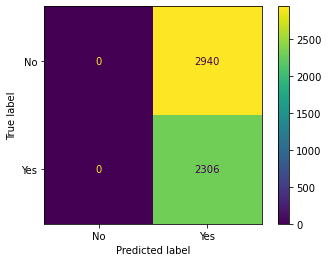

In [37]:
# Creating confusion matrix
cf = confusion_matrix(y_train, y_pred)
# Displaying confusion matrix
ConfusionMatrixDisplay(cf, display_labels=['No', 'Yes']).plot()

In [38]:
recall_scorer = make_scorer(recall_score, pos_label='Yes')
f1_scorer = make_scorer(f1_score, pos_label='Yes')

In [39]:
# Cross Validation Scores
print('CV Recall: ', cross_val_score(dummy_model, X_train, y_train, scoring=recall_scorer).mean())
print('CV F1: ', cross_val_score(dummy_model, X_train, y_train, scoring=f1_scorer).mean())
print('CV Accuracy: ', cross_val_score(dummy_model, X_train, y_train).mean())

CV Recall:  1.0
CV F1:  0.6106990434142753
CV Accuracy:  0.43957292659675884


### First Model: Decision Tree 

In [41]:
# # Creating steps for a Pipeline 
# tree_steps = [('smote', SMOTE(random_state=333)),
#               ('tree', DecisionTreeClassifier())]
# # Feeding the Pipeline the steps defined above
# tree_pipe = Pipeline(tree_steps)
# # Fitting the training data to the Pipeline
# tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=333)),
                ('tree', DecisionTreeClassifier())])

In [42]:
# # Pickle the model
# with open('tree_pipe.pkl', 'wb') as f:
#     pickle.dump(tree_pipe, f)

In [41]:
# Load the pickled model
with open('tree_pipe.pkl', 'rb') as f:
    tree_pipe = pickle.load(f)

In [ ]:
# Load the pickled model
with open('tree_pipe.pkl', 'rb') as f:
    tree_pipe = pickle.load(f)

In [42]:
# Defining the predictions from the Pipeline using the training data
y_pred = tree_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
print('Recall: ', recall_score(y_train, y_pred, pos_label='Yes'))
print('F1: ', f1_score(y_train, y_pred, pos_label='Yes'))
print('Accuracy: ', accuracy_score(y_train, y_pred))

Recall:  1.0
F1:  1.0
Accuracy:  1.0


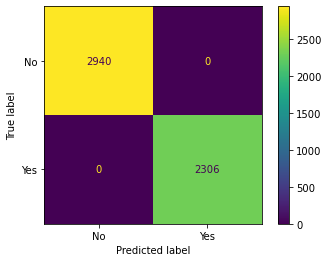

In [43]:
# Creating confusion matrix
cf = confusion_matrix(y_train, y_pred)
# Displaying confusion matrix
ConfusionMatrixDisplay(cf, display_labels=['No', 'Yes']).plot()

In [44]:
# Cross Validation Scores
print('CV Recall: ', cross_val_score(tree_pipe, X_train, y_train, scoring=recall_scorer).mean())
print('CV F1: ', cross_val_score(tree_pipe, X_train, y_train, scoring=f1_scorer).mean())
print('CV Accuracy: ', cross_val_score(tree_pipe, X_train, y_train).mean())

CV Recall:  0.4887248687682527
CV F1:  0.4748533553324902
CV Accuracy:  0.5284023786826456


### Second Model: Random Forest

In [ ]:
# Creating steps for a Pipeline 
forest_steps = [('smote', SMOTE(random_state=333)),
                ('forest', RandomForestClassifier(random_state=333))]
# Feeding the Pipeline the steps defined above
forest_pipe = Pipeline(forest_steps)
# Fitting the training data to the Pipeline
forest_pipe.fit(X_train, y_train)

In [ ]:
# Pickle the model
with open('forest_pipe.pkl', 'wb') as f:
    pickle.dump(forest_pipe, f)

In [ ]:
# Load the pickled model
with open('forest_pipe.pkl', 'rb') as f:
    forest_pipe = pickle.load(f)

In [ ]:
# Scores for model
# Defining the predictions from the Pipeline using the training data
y_pred = forest_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
print('Recall: ', recall_score(y_train, y_pred, pos_label='Yes'))
print('F1: ', f1_score(y_train, y_pred, pos_label='Yes'))
print('Accuracy: ', accuracy_score(y_train, y_pred))

In [ ]:
# Creating confusion matrix
cf = confusion_matrix(y_train, y_pred)
# Displaying confusion matrix
ConfusionMatrixDisplay(cf, display_labels=['No', 'Yes']).plot()

In [ ]:
# Cross Validation Scores for model
model = forest_pipe
print('CV Recall: ', cross_val_score(model, X_train, y_train, scoring=recall_scorer).mean())
print('CV F1: ', cross_val_score(model, X_train, y_train, scoring=f1_scorer).mean())
print('CV Accuracy: ', cross_val_score(model, X_train, y_train).mean())

### Random Forest with GridSearch 1

In [ ]:
##Recall
# Creating parameters for GridSearch
params = {'forest__n_estimators': [50, 100, 150],
          'forest__criterion': ['gini', 'entropy'],
          'forest__max_depth': [10, None],
          'forest__min_samples_split': [1, 2],
          'forest__min_weight_fraction_leaf': [0, .5],
         'forest__max_features': ['auto', None, 15],
          'forest__max_leaf_nodes': [None, 10],
          'forest__min_impurity_decrease': [0, .5],
         }
# GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
forest_grid1 = GridSearchCV(estimator=forest_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)
# Fitting the GridSearch
forest_grid1.fit(X_train, y_train)

In [ ]:
# Pickle the model
with open('forest_grid1.pkl', 'wb') as f:
    pickle.dump(forest_grid1, f)

In [ ]:
# Load the pickled model
with open('forest_grid1.pkl', 'rb') as f:
    forest_grid1 = pickle.load(f)

In [ ]:
print("Recall")
print(forest_grid1.best_estimator_)
print(forest_grid1.best_score_)

In [ ]:
model = forest_grid1.best_estimator_
# Cross Validation Scores for model
print('CV Recall: ', cross_val_score(model, X_train, y_train, scoring=recall_scorer).mean())
print('CV F1: ', cross_val_score(model, X_train, y_train, scoring=f1_scorer).mean())
print('CV Accuracy: ', cross_val_score(model, X_train, y_train).mean())

#### Random Forest with GridSearch 2

In [ ]:
##Recall
# Creating parameters for GridSearch
params = {'forest__n_estimators': [150, 160, 140],
          'forest__criterion': ['gini'],
          'forest__max_depth': [30, 10],
          'forest__min_samples_split': [3, 2],
          'forest__min_weight_fraction_leaf': [.75, .5, .25],
         'forest__max_features': [30, 20, None],
          'forest__max_leaf_nodes': [None, 2],
          'forest__min_impurity_decrease': [0, .25],
         }
# GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
forest_grid2 = GridSearchCV(estimator=forest_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)
# Fitting the GridSearch
forest_grid2.fit(X_train, y_train)

In [ ]:
# Pickle the model
with open('forest_grid2.pkl', 'wb') as f:
    pickle.dump(forest_grid2, f)

In [ ]:
# Load the pickled model
with open('forest_grid2.pkl', 'rb') as f:
    forest_grid2 = pickle.load(f)

In [ ]:
print("Recall")
print(forest_grid2.best_estimator_)
print(forest_grid2.best_score_)

#### Random Forest with Grid Search 3

In [ ]:
##Recall
# Creating parameters for GridSearch
params = {'forest__n_estimators': [145, 155, 150],
          'forest__criterion': ['gini'],
          'forest__max_depth': [30, 20, 40],
          'forest__min_samples_split': [3, 4],
          'forest__min_weight_fraction_leaf': [.2, .3, .25],
         'forest__max_features': [30, 40, 50],
          'forest__max_leaf_nodes': [1, 2, 3],
          'forest__min_impurity_decrease': [0, .1],
         }
# GridSearch with the random forest pipeline, parameters above, 5 fold cross validation, and accuracy score
forest_grid3 = GridSearchCV(estimator=forest_pipe, param_grid=params, cv=5, scoring=recall_scorer, verbose=2)
# Fitting the GridSearch
forest_grid3.fit(X_train, y_train)

In [ ]:
# Pickle the model
with open('forest_grid3.pkl', 'wb') as f:
    pickle.dump(forest_grid3, f)

In [ ]:
# Load the pickled model
with open('forest_grid3.pkl', 'rb') as f:
    forest_grid3 = pickle.load(f)

In [ ]:
print("Recall")
print(forest_grid3.best_estimator_)
print(forest_grid3.best_score_)

### Third Model: Logistic Regression

In [ ]:
# Creating steps for a Pipeline 
logreg_steps = [('smote', SMOTE(random_state=333)),
                ('logreg', LogisticRegression(random_state=333))]
# Feeding the Pipeline the steps defined above
logreg_pipe = Pipeline(logreg_steps)
# Fitting the training data to the Pipeline
logreg_pipe.fit(X_train, y_train)

In [ ]:
# Pickle the model
with open('logreg_pipe.pkl', 'wb') as f:
    pickle.dump(logreg_pipe, f)

In [ ]:
# Load the pickled model
with open('logreg_pipe.pkl', 'rb') as f:
    logreg_pipe = pickle.load(f)

In [ ]:
# Scores for model
# Defining the predictions from the Pipeline using the training data
y_pred = logreg_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
print('Recall: ', recall_score(y_train, y_pred, pos_label='Yes'))
print('F1: ', f1_score(y_train, y_pred, pos_label='Yes'))
print('Accuracy: ', accuracy_score(y_train, y_pred))

In [ ]:
# Creating confusion matrix
cf = confusion_matrix(y_train, y_pred)
# Displaying confusion matrix
ConfusionMatrixDisplay(cf, display_labels=['No', 'Yes']).plot()

In [ ]:
# Cross Validation Scores for model
model = logreg_pipe
print('CV Recall: ', cross_val_score(model, X_train, y_train, scoring=recall_scorer).mean())
print('CV F1: ', cross_val_score(model, X_train, y_train, scoring=f1_scorer).mean())
print('CV Accuracy: ', cross_val_score(model, X_train, y_train).mean())

#### Logistic Regression with GridSearch 1

In [ ]:
# Creating parameters for GridSearch
logreg_params = {'logreg__class_weight':['balanced', None, [1, 10]],
                'logreg__C': [1, 0.0001],
                'logreg__solver': ['lbfgs', 'sag', 'saga'],
                'logreg__max_iter': [100],
                'logreg__penalty': ['l1', 'l2']}
# GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
logreg_grid1 = GridSearchCV(estimator=logreg_pipe, param_grid=logreg_params, cv=5, scoring=recall_scorer, verbose=2)
# Fitting the GridSearch
logreg_grid1.fit(X_train, y_train)

In [ ]:
# Pickle the model
with open('logreg_grid1.pkl', 'wb') as f:
    pickle.dump(logreg_grid1, f)

In [ ]:
# Load the pickled model
with open('logreg_grid1.pkl', 'rb') as f:
    logreg_grid1 = pickle.load(f)

In [ ]:
print("Recall")
print(logreg_grid1.best_estimator_)
print(logreg_grid1.best_score_)

#### Logistic Regression with GridSearch 2

In [ ]:
# Creating parameters for GridSearch
logreg_params = {'logreg__class_weight':['balanced', [1, 20], [20, 1], [1, 50]],
                'logreg__C': [1, 10, 100],
                'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg'],
                'logreg__max_iter': [50, 100, 150, 1000],
                'logreg__penalty': ['elasticnet', 'l2', None]}
# GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
logreg_grid2 = GridSearchCV(estimator=logreg_pipe, param_grid=logreg_params, cv=5, scoring=recall_scorer, verbose=2)
# Fitting the GridSearch
logreg_grid2.fit(X_train, y_train)

#LogReg to see parameters when changing params
# LogisticRegression(random_state=333)

In [ ]:
# Pickle the model
with open('logreg_grid2.pkl', 'wb') as f:
    pickle.dump(logreg_grid2, f)

In [ ]:
# Load the pickled model
with open('logreg_grid2.pkl', 'rb') as f:
    logreg_grid2 = pickle.load(f)

In [ ]:
print("Recall")
print(logreg_grid2.best_estimator_)
print(logreg_grid2.best_score_)

#### Logistic Regression with GridSearch 3

In [ ]:
# Creating parameters for GridSearch
logreg_params = {'logreg__class_weight':['balanced'],
                'logreg__C': [1, .01, .001],
                'logreg__solver': ['lbfgs'],
                'logreg__max_iter': [100, 125, 200, 300],
                'logreg__penalty': ['l2']}
# GridSearch with the logistic regression pipeline, parameters above, 5 fold cross validation, and accuracy score
logreg_grid3 = GridSearchCV(estimator=logreg_pipe, param_grid=logreg_params, cv=5, scoring=recall_scorer, verbose=2)
# Fitting the GridSearch
logreg_grid3.fit(X_train, y_train)

In [ ]:
# Pickle the model
with open('logreg_grid3.pkl', 'wb') as f:
    pickle.dump(logreg_grid3, f)

In [ ]:
# Load the pickled model
with open('logreg_grid3.pkl', 'rb') as f:
    logreg_grid3 = pickle.load(f)

In [ ]:
print("Recall")
print(logreg_grid3.best_estimator_)
print(logreg_grid3.best_score_)

In [ ]:
# Cross Validation Scores for model
model = logreg_grid3.best_estimator_
print('CV Recall: ', cross_val_score(model, X_train, y_train, scoring=recall_scorer).mean())
print('CV F1: ', cross_val_score(model, X_train, y_train, scoring=f1_scorer).mean())
print('CV Accuracy: ', cross_val_score(model, X_train, y_train).mean())

### Fourth Model: Neural Network

In [ ]:
# Creating steps for a Pipeline 
neural_steps = [('smote', SMOTE(random_state=333)),
                ('neural', MLPClassifier(random_state=333))]
# Feeding the Pipeline the steps defined above
neural_pipe = Pipeline(neural_steps)
# Fitting the training data to the Pipeline
neural_pipe.fit(X_train, y_train)

In [ ]:
# Pickle the model
with open('neural_pipe.pkl', 'wb') as f:
    pickle.dump(neural_pipe, f)

In [ ]:
# Load the pickled model
with open('neural_pipe.pkl', 'rb') as f:
    neural_pipe = pickle.load(f)

In [ ]:
# Scores for model
# Defining the predictions from the Pipeline using the training data
y_pred = neural_pipe.predict(X_train)
# Evaluating the accuracy score on the training data
print('Recall: ', recall_score(y_train, y_pred, pos_label='Yes'))
print('F1: ', f1_score(y_train, y_pred, pos_label='Yes'))
print('Accuracy: ', accuracy_score(y_train, y_pred))

In [ ]:
# Creating confusion matrix
cf = confusion_matrix(y_train, y_pred)
# Displaying confusion matrix
ConfusionMatrixDisplay(cf, display_labels=['No', 'Yes']).plot()

In [ ]:
# Cross Validation Scores for model
model = neural_pipe
print('CV Recall: ', cross_val_score(model, X_train, y_train, scoring=recall_scorer).mean())
print('CV F1: ', cross_val_score(model, X_train, y_train, scoring=f1_scorer).mean())
print('CV Accuracy: ', cross_val_score(model, X_train, y_train).mean())